In [83]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# choice points <6 hexes away from ports
ILLEGAL_CHOICE_POINTS = [4, 6, 5, 11, 8, 10, 7, 9, 49, 38, 47, 32, 42, 27, 37, 46, 48, 43, 33, 39, 28, 44, 34, 23]

# Generate a range from 5-47 (all possible hexes), but exclude the hexes right next to the reward ports
POSSIBLE_BARRIERS = np.arange(5, 48)
POSSIBLE_BARRIERS = POSSIBLE_BARRIERS[~np.isin(POSSIBLE_BARRIERS, [5, 6, 33, 38, 43, 47])]

## Define a bunch of functions

def create_hex_maze():
    '''
    Use networkx to create a graph representing the empty hex maze before any barriers are added.
    
    Returns: a networkx graph representing all of the hexes in the hex maze
    ''' 
    empty_hex_maze = nx.Graph()
    
    # Define all nodes and edges to create the empty maze
    add_edges_to_node(empty_hex_maze, 1, [4])
    add_edges_to_node(empty_hex_maze, 4, [1, 5, 6])
    add_edges_to_node(empty_hex_maze, 6, [4, 8])
    add_edges_to_node(empty_hex_maze, 5, [4, 7])
    add_edges_to_node(empty_hex_maze, 8, [6, 11, 10])
    add_edges_to_node(empty_hex_maze, 7, [5, 10, 9])
    add_edges_to_node(empty_hex_maze, 11, [8, 14])
    add_edges_to_node(empty_hex_maze, 10, [8, 7, 13])
    add_edges_to_node(empty_hex_maze, 9, [7, 12])
    add_edges_to_node(empty_hex_maze, 14, [11, 18, 17])
    add_edges_to_node(empty_hex_maze, 13, [10, 17, 16])
    add_edges_to_node(empty_hex_maze, 12, [9, 16, 15])
    add_edges_to_node(empty_hex_maze, 18, [14, 22])
    add_edges_to_node(empty_hex_maze, 17, [14, 13, 21])
    add_edges_to_node(empty_hex_maze, 16, [13, 12, 20])
    add_edges_to_node(empty_hex_maze, 15, [12, 19])
    add_edges_to_node(empty_hex_maze, 22, [18, 27, 26])
    add_edges_to_node(empty_hex_maze, 21, [17, 26, 25])
    add_edges_to_node(empty_hex_maze, 20, [16, 25, 24])
    add_edges_to_node(empty_hex_maze, 19, [15, 24, 23])
    add_edges_to_node(empty_hex_maze, 27, [22, 32])
    add_edges_to_node(empty_hex_maze, 26, [22, 21, 31])
    add_edges_to_node(empty_hex_maze, 25, [21, 20, 30])
    add_edges_to_node(empty_hex_maze, 24, [20, 19, 29])
    add_edges_to_node(empty_hex_maze, 23, [19, 28])
    add_edges_to_node(empty_hex_maze, 32, [27, 38, 37])
    add_edges_to_node(empty_hex_maze, 31, [26, 37, 36])
    add_edges_to_node(empty_hex_maze, 30, [25, 36, 35])
    add_edges_to_node(empty_hex_maze, 29, [24, 35, 34])
    add_edges_to_node(empty_hex_maze, 28, [23, 34, 33])
    add_edges_to_node(empty_hex_maze, 38, [32, 49])
    add_edges_to_node(empty_hex_maze, 37, [31, 32, 42])
    add_edges_to_node(empty_hex_maze, 36, [30, 31, 41])
    add_edges_to_node(empty_hex_maze, 35, [29, 30, 40])
    add_edges_to_node(empty_hex_maze, 34, [28, 29, 39])
    add_edges_to_node(empty_hex_maze, 33, [28, 48])
    add_edges_to_node(empty_hex_maze, 49, [2, 38, 47])
    add_edges_to_node(empty_hex_maze, 42, [37, 46, 47])
    add_edges_to_node(empty_hex_maze, 41, [36, 45, 46])
    add_edges_to_node(empty_hex_maze, 40, [35, 44, 45])
    add_edges_to_node(empty_hex_maze, 39, [34, 43, 44])
    add_edges_to_node(empty_hex_maze, 48, [3, 33, 43])
    add_edges_to_node(empty_hex_maze, 2, [49])
    add_edges_to_node(empty_hex_maze, 47, [49, 42])
    add_edges_to_node(empty_hex_maze, 46, [42, 41])
    add_edges_to_node(empty_hex_maze, 45, [41, 40])
    add_edges_to_node(empty_hex_maze, 44, [40, 39])
    add_edges_to_node(empty_hex_maze, 43, [39, 48])
    add_edges_to_node(empty_hex_maze, 3, [48])
    return empty_hex_maze
    

def add_edges_to_node(graph, node, edges):
    '''
    Add all edges to the specified node in the graph. 
    If the node does not yet exist in the graph, add the node.
    '''
    for edge in edges:
        graph.add_edge(node, edge)
        
def find_all_critical_choice_points(graph):
    '''
    Given a graph representing the hex maze, 
    find all critical choice points between reward ports 1, 2, and 3.
    
    Returns: a set of all critical choice points
    '''
    paths12 = list(nx.all_shortest_paths(G, source=1, target=2))
    paths13 = list(nx.all_shortest_paths(G, source=1, target=3))
    paths23 = list(nx.all_shortest_paths(G, source=2, target=3))
    
    choice_points = set()
    # all choice points from port 1
    for path_a in paths12:
        for path_b in paths13:
            shared_path = [hex for hex in path_a if hex in path_b]
            choice_points.add(shared_path[-1])
    
    # all choice points from port 2
    for path_a in paths12:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b]
            choice_points.add(shared_path[-1])
            
    # all choice points from port 3
    for path_a in paths13:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b[::-1]]
            choice_points.add(shared_path[-1])
    return choice_points

def is_valid_maze(graph):
    '''
    Given a graph representing a possible hex maze configuration, check if it is valid 
    using the following criteria: 
    - all reward ports are reachable
    - path lengths between reward ports are between 15-25 hexes
    - there are no groups of >2 inaccessible hexes
    - all critical choice points are >=6 hexes away from a reward port
    
    If it is invalid, print out the reason why.
    
    Returns: True if the hex maze is valid, False otherwise
    '''
    # Make sure all ports are reachable
    if not nx.has_path(graph, 1, 2) or not nx.has_path(graph, 1, 3) or not nx.has_path(graph, 2, 3):
        print("BAD MAZE: At least one reward port is not reachable!")
        return False
    
    # Make sure path lengths are between 15-25
    len12 = nx.shortest_path_length(G, source=1, target=2)
    len13 = nx.shortest_path_length(G, source=1, target=3)
    len23 = nx.shortest_path_length(G, source=2, target=3)
    reward_port_lengths = [len12, len13, len23]
    if min(reward_port_lengths) <= 13:
        print("BAD MAZE: Path between reward ports is too short (<=13)")
        return False
    if max(reward_port_lengths) - min(reward_port_lengths) < 4:
        print("BAD MAZE: Distance difference in reward port paths is too small (<4)")
        return False
    if max(reward_port_lengths) > 25:
        print("BAD MAZE: Path between reward ports is too long (>25)")
        return False
    
    # Make sure there are no groups of >2 inaccessible hexes
    if not nx.is_connected(G):
        # If not connected, get each separate component
        connected_components = list(nx.connected_components(G))
        for component in connected_components:
            if 3 <= len(component) <= 35:
                print("BAD MAZE: Group of >2 inaccessible hexes")
                return False
            
    # Make sure all critical choice points are >=6 hexes away from a reward port
    choice_points = find_all_critical_choice_points(G)
    if any(hex in ILLEGAL_CHOICE_POINTS for hex in choice_points):
        print("BAD MAZE: Choice point <6 hexes away from reward port")
        return False
    
    return True

Barriers we randomly selected:
[41 19 36 14 28 39 17 26 24]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[42 23 35 45 15 10 32 13 21]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[15 18 24  7 39 30 25  9 22]
BAD MAZE: Choice point <6 hexes away from reward port
Barriers we randomly selected:
[14  9 26 11 13 15 18  8 17]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[36 32 20 18 13 21 17 23 19]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[28 39 22 45 25 42 13 14  8]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[34 29 24 22 10 17 36 20 44]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[29  7 45 23 41 32 17 25 44]
BAD MAZE: At least one reward port is not reachable!
Barriers we randomly selected:
[18 12 16 42 15 23 37  8 46]
BAD MAZE: Distance difference in re

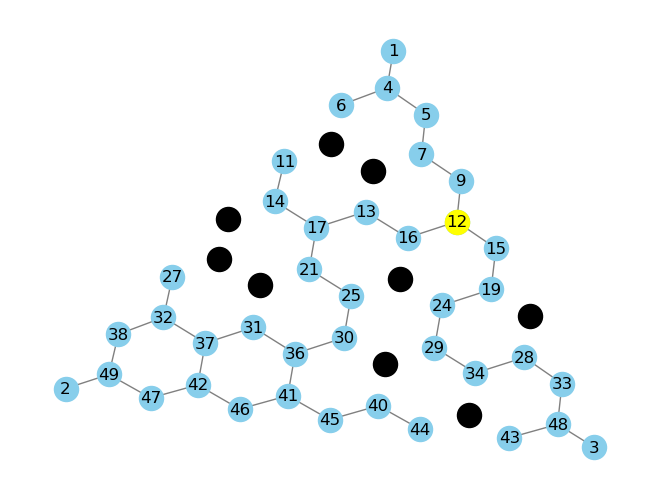

In [89]:
# Create the empty hex maze
G_original = create_hex_maze()

# Generate a set of 9 random barriers until we get a good maze
is_good_maze = False
while not is_good_maze:
    # Create copy of the empty maze to mess with
    G = G_original.copy()

    # Randomly select 9 barriers
    barriers = np.random.choice(possible_barriers, size=9, replace=False)
    print("Barriers we randomly selected:")
    print(barriers)
    
    # Add the barriers to the empty maze
    for barrier in barriers:
        G.remove_node(barrier)
        
    # Check if this is a good maze
    is_good_maze = is_valid_maze(G)

# Once we get a good maze, print some stuff about it
print("Shortest path between 1 and 2:", nx.shortest_path(G, source=1, target=2))
print("Length of path:", len(nx.shortest_path(G, source=1, target=2)))
print("Shortest path between 1 and 3:", nx.shortest_path(G, source=1, target=3))
print("Length of path:", len(nx.shortest_path(G, source=1, target=3)))
print("Shortest path between 2 and 3:", nx.shortest_path(G, source=2, target=3))
print("Length of path:", len(nx.shortest_path(G, source=2, target=3)))

print("Critical choice point(s):")
choice_points = find_all_critical_choice_points(G)
print(choice_points)

# Get the graph layout of the original maze
pos = nx.kamada_kawai_layout(G_original)

# Draw the available hexes using this layout
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')

# Add the barriers in black
for barrier in barriers:
        nx.draw_networkx_nodes(G_original, pos, nodelist=[barrier], node_color='black')

# Make the choice points yellow
for choice_point in choice_points:
        nx.draw_networkx_nodes(G_original, pos, nodelist=[choice_point], node_color='yellow')
        
plt.show()